# Automatic Farm Boundary Extraction using U-Net model

```
This notebook shows step by step on training a U-Net model for automatic farm boundary extraction on Sentinel-2 Images.

The data used in this training proces is the Netherlands Farm Boundary data obtained from doi.org/10.17026/dans-za6-m8t7

The code used in this notebook are modified from https://github.com/resingm/field-boundary-delineation
```

In [ ]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
import rasterio as rio
import sys
import typing
from osgeo import gdal
import keras
import tensorflow as tf
import segmentation_models as sm
from skimage import exposure

# Install patchify library for python
# !pip install patchify

# If using google colab, define dataset directory
# from google.colab import drive

Segmentation Models: using `keras` framework.


In [ ]:
# Provide the folder directory like below
BASE_PATH = "data"
INPUT_PATH = BASE_PATH + "/Classified Data/"
OUTPUT_PATH = BASE_PATH + "/Networks"
IMAGE_PATH = "/Original"
LABEL_PATH = "/Classified"

INCLUDE_FOLDERS = ["Flevoland", "Friesland", "Gelderland", "Limburg", "Overijssel", "Zeeland", "Zuid-Holland"]


LEGEND = {
    0: 'Other',
    1: 'Field Boundary'
}

In [ ]:
# ################################################################
# Loading input data
#
# Input data is loaded into two dictionaries:
#
# images: contains the 4-band images. The values are loaded as ints.
# labels: contains 3D arrays in which each pixel is assigned with
#         a label "0" = other and "1" = field boundary
#
# ################################################################

def key_generator(file_name):
    """Generates the key of a file based on the file name. The resulting key is
    a tuple of the province as string & the file number index as int,
    e.g. ("gelderland", 29)
    """
    file_name = file_name.lower()
    file_name = file_name.replace("classified_", "")
    file_name = file_name.replace("original_", "")
    file_name = file_name.replace(".tif", "")
    (province, index) = tuple(file_name.split("_"))
    index = int(index)
    return (province, index)

def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

def gtiff_to_array(file_path):
    """Takes a image file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = rio.open(file_path)
    bd1_array = data.read(1) #BLUE
    bd2_array = data.read(2) #GREEN
    bd3_array = data.read(3) #RED
    bd4_array = data.read(4) #NIR
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)
    #bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.dstack((b03_norm, b02_norm, b01_norm, b04_norm))

def gtiff_to_array_mask(file_path):
    """Takes a mask file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = rio.open(file_path)
    bd1_array = data.read(1)
    bd2_array = data.read(2)
    bd3_array = data.read(3)
    return np.dstack((bd1_array, bd2_array, bd3_array))

def transform_classification_image(input):
    """Takes the classification image input (in RGB format as 3D array) and
    creates a 2D array out of this. The innermost array expects either values of
    [0, 0, 0] of [255, 255, 255] since this is the colouring we assigned to the
    classified images.

    :param input: 3D input image (classification)
    :return: 2D array image with labels 1 for 'other' and 2 for 'field_boundaries'
    """

    # Out of the 3D input array it takes the "max" element out of the array
    # This will either be 0 or 255. This function is just called to transform
    # the 3D array to a 2D array.
    result = np.reshape(np.max(input, axis=2), (input.shape[0], input.shape[1], 1))

    # Now the array consists of pixels with values "0" or "255". We transform
    # each value, that is larger than 0 (i.e. 255) and assign the label "2" to
    # it. Each other element (i.e. 0) will get assigned the label "1".
    result = np.where(result > 0, 1, 0)
    return result

# Dictionaries which contain the input data
images = {}
labels = {}

# Iterate through defined folders and load all image data into the dictionaries
# image_data and label_data. Images can be accessed with (<province>, <index>)
for folder in INCLUDE_FOLDERS:
    original = INPUT_PATH + folder + IMAGE_PATH
    classified = INPUT_PATH + folder + LABEL_PATH
    for f in os.listdir(original):
        value = gtiff_to_array(original + "/" + f)
        key = key_generator(f)
        images[key] = value
    for f in os.listdir(classified):
        value = gtiff_to_array_mask(classified + "/" + f)

        # Transform the classification image from RGB to labels "1" and "2"
        value = transform_classification_image(value)
        key = key_generator(f)
        labels[key] = value

    print(f"{folder} image tiles: {len(os.listdir(original))}")
    print(f"{folder} label tiles: {len(os.listdir(classified))}")


print(f"Shape of sample image file: {list(images.values())[0].shape}")
print(f"Shape of sample label file: {list(labels.values())[0].shape}")

print(f"Total number of image & label tiles: {len(images)}")


Flevoland image tiles: 19
Flevoland label tiles: 19
Friesland image tiles: 24
Friesland label tiles: 24
Gelderland image tiles: 3
Gelderland label tiles: 3
Limburg image tiles: 5
Limburg label tiles: 5
Overijssel image tiles: 36
Overijssel label tiles: 36
Zeeland image tiles: 32
Zeeland label tiles: 32
Zuid-Holland image tiles: 3
Zuid-Holland label tiles: 3
Shape of sample image file: (800, 800, 4)
Shape of sample label file: (800, 800, 1)
Total number of image & label tiles: 122


In [ ]:
# ################################################################
# Split input data into training & test set
#
# Takes the entire input and splits the data into a training data
# set and test data set. The proportions are defined as follows:
#
#     Size_training = Size_input * RELATIVE_TRAINING_SIZE
#     Size_test = Size_input * (1 - RELATIVE_TRAINING_SIZE)
#
# The resulting data sets are mutually exclusive, e.g.:
#     Set_training | Set_test = Set_input
#     Set_training & Set_test = []
#
#     Remark: (| = Union, & = Intersection, [] = empty set)
#
# ################################################################

import random

# Constants to sample test & training set
SEED = 34
RELATIVE_TRAINING_SIZE = 0.9

def calculate_k(n):
    """Splitting the input data into training & test requires a variable called
    'k'. 'k' defines the size of the subset of a variable.

    :param n: Size of which k has to be calculated from
    :return: k
    """
    k = RELATIVE_TRAINING_SIZE * n
    return int(k)

# Create a generator with predefined SEED
random_generator = random.Random(SEED)

# Entire set of keys
keys = set(images.keys())

# Split key_set into x_train_keys and x_test_keys
keys_train = set(random_generator.sample(keys, calculate_k(len(keys))))
keys_test = keys - keys_train

# Generate dictionaries with training data
x_train_dict = { k : images[k] for k in keys_train }
y_train_dict = { k : labels[k] for k in keys_train }

# Generate dictionaries with test data
x_test_dict = { k : images[k] for k in keys_test }
y_test_dict = { k : labels[k] for k in keys_test }


# Print key set of each set
print(x_train_dict.keys())
print(x_test_dict.keys())


dict_keys([('overijssel', 60), ('zeeland', 49), ('overijssel', 5), ('friesland', 162), ('overijssel', 14), ('zeeland', 3), ('limburg', 166), ('flevoland', 20), ('zeeland', 76), ('flevoland', 93), ('friesland', 137), ('zeeland', 51), ('overijssel', 7), ('overijssel', 71), ('overijssel', 16), ('flevoland', 22), ('friesland', 176), ('flevoland', 95), ('overijssel', 46), ('zeeland', 35), ('overijssel', 18), ('zeeland', 62), ('zeeland', 7), ('flevoland', 79), ('friesland', 178), ('friesland', 123), ('gelderland', 37), ('zeeland', 37), ('overijssel', 57), ('overijssel', 2), ('zeeland', 64), ('friesland', 180), ('overijssel', 32), ('friesland', 134), ('zeeland', 21), ('gelderland', 30), ('overijssel', 59), ('overijssel', 4), ('zeeland', 48), ('flevoland', 65), ('overijssel', 34), ('zeeland', 23), ('overijssel', 98), ('friesland', 136), ('overijssel', 43), ('zeeland', 32), ('zeeland', 50), ('overijssel', 70), ('friesland', 166), ('flevoland', 21), ('friesland', 175), ('flevoland', 94), ('zeela

('overijssel', 60)


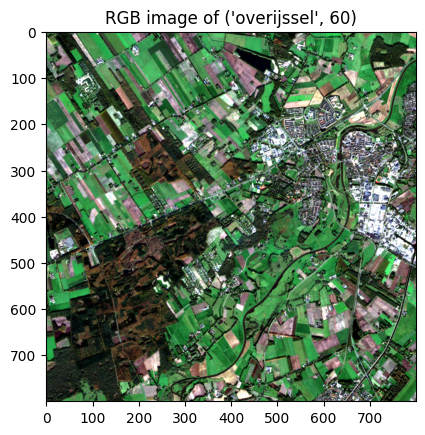

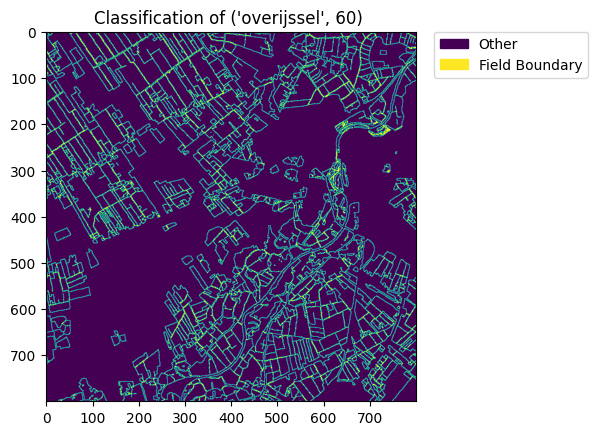

In [ ]:
# ################################################################
# Visualize some sample input data
#
# Helps to verify that the data is correct and also supports the
# thinking process if trying to debug the program.
# ################################################################

from matplotlib import patches, pyplot


def visualize_labels(arr, title, legend_labels):
    """Visualize the labels prepared from the reference images.

    :param arr: 3D array of an image to display
    :param title: Title to assign to the output
    :param label: Labels to use in the legend
    """
    fig = pyplot.figure()

    a = fig.add_subplot(1, 1, 1)
    a.set_title(title)

    values = np.unique(arr.ravel())
    im = pyplot.imshow(arr[:, :, 0])

    # get the colors of the values according to the color map used by imshow
    colors = [im.cmap(im.norm(v)) for v in values]

    # Generate a legend
    legend = []
    for i, v in enumerate(values):
        legend.append(patches.Patch(
            color=colors[i],
            label=legend_labels[v]
        ))
    pyplot.legend(handles=legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_data(arr, title):
    """Visualize the satellite image data.

    :param arr: Input image (4 bands, the first 3 will be printed)
    :param title: Title of the plot
    """
    # Switching bands:
    #     blue green red
    #     red  green blue

    data = arr[:, :, 0:-1]
    # red = data[:, :, 0].copy()
    # data[:, :, 0] = data[:, :, 2]
    # data[:, :, 2] = red

    # Should be already the case if normalization is included
    data = data.astype(np.float32)

    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = pyplot.figure()
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    pyplot.imshow(data)


key = list(x_train_dict.keys())[0]
print(key)
# key = ('overijssel', 17)
visualize_data(images[key], f"RGB image of {key}")
visualize_labels(labels[key], f"Classification of {key} ", LEGEND)


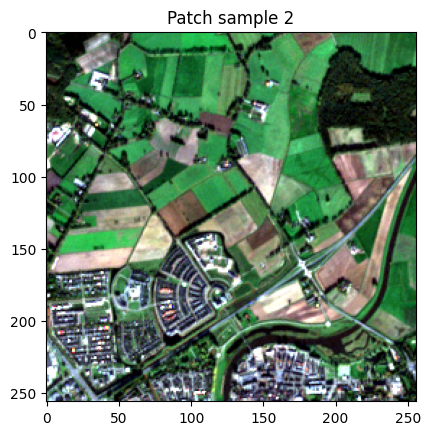

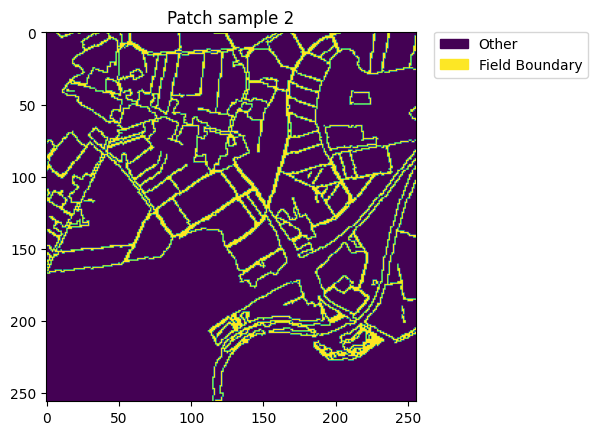

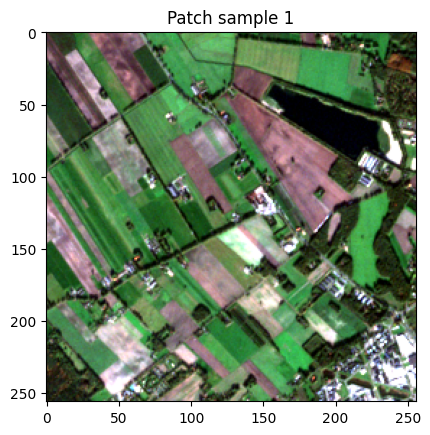

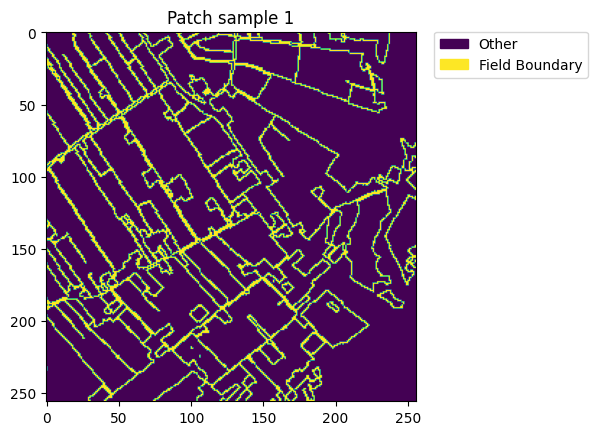

In [ ]:
# Crop Images into smaller and uniform patch size for training purpose

from patchify import patchify

PATCHSIZE = 256
NBANDS = list(images.values())[0].shape[-1]

def perform_gridwise_sampling(img, patchsize):
    """Takes an input array with 3 dimensions and returns a 4 dimension array
    where the outermost dimension consists of patches out of the image.
    Patches are cut gridwise out of a grid with patchsize x patchsize pixels

    :param img: 3D input array of an image
    :param patchsize: The size of a patch
    :return: input image split into multiple patches in 4D array
    """
    n = img.shape[2]
    s = patchsize # to keep the code lines short

    patches_img = patchify(img, (s, s, n), step=s)

    patches = np.zeros(
        shape=(0, s, s, n),
        dtype=img.dtype
    )

    for row in range(patches_img.shape[0]):
        for col in range(patches_img.shape[1]):
            # create patch, expand the dimension and add it to the samples
            # patch = img[row * s : (row + 1) * s, col * s : (col + 1) * s, :]
            patch = patches_img[row, col, :, :]
            #patch = np.expand_dims(patch, axis=0)
            patches = np.concatenate((patches, patch), axis=0)

    return patches


x_train = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
y_train = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)


for k in x_train_dict.keys():
    # Create patches
    x_patches = perform_gridwise_sampling(x_train_dict[k], PATCHSIZE)
    y_patches = perform_gridwise_sampling(y_train_dict[k], PATCHSIZE)

    # Insert patches into x_train and y_train data set
    x_train = np.concatenate((x_train, x_patches), axis=0)
    y_train = np.concatenate((y_train, y_patches), axis=0)


# Print a sample set of the data set to verify, samples are created properly
sample_size = 2

while sample_size:
    visualize_data(x_train[sample_size], f"Patch sample {sample_size}")
    visualize_labels(y_train[sample_size], f"Patch sample {sample_size}", LEGEND)
    # print(x_train[sample_size].shape)
    # print(y_train[sample_size].shape)
    sample_size -= 1


In [ ]:
# Train and validation data split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Number of training patches: ", len(x_train))
print("Number of validation patches: ", len(x_val))

Number of training patches:  780
Number of validation patches:  196


# Model Training

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, num_channels]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

In [ ]:
def learning_rate_scheduler(epoch):
    lr = 1e-4
    '''
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    '''
    print("Set Learning Rate : {}".format(lr))
    return lr

In [ ]:
# Specify model training parameters.
num_channels = 4
BATCH_SIZE = 16
EPOCHS = 100
OPTIMIZER = optimizers.Adam()
LOSS = losses.BinaryCrossentropy()
METRICS = ['Precision', 'Recall']

In [ ]:
# Define the model
model = get_model()
#model.summary()

2023-06-30 05:05:07.006155: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('NL_unet_nl.h5', verbose=1, save_best_only=True)
logger = tf.keras.callbacks.TensorBoard(log_dir='logs')

callbacks = [logger, checkpointer]

In [ ]:
history = model.fit(x=x_train, y=y_train,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = len(x_train)//BATCH_SIZE,
                    validation_steps = len(x_val)//BATCH_SIZE,
                    callbacks=callbacks,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

2023-06-29 12:45:25.178278: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 817889280 exceeds 10% of free system memory.
2023-06-29 12:45:26.029472: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 817889280 exceeds 10% of free system memory.


Epoch 1/100
48/48 [==============================] - ETA: 0s - loss: 0.3857 - precision: 0.1727 - recall: 0.0243
Epoch 1: val_loss improved from inf to 1.30804, saving model to NL_unet_nl.h5
48/48 [==============================] - 135s 1s/step - loss: 0.3857 - precision: 0.1727 - recall: 0.0243 - val_loss: 1.3080 - val_precision: 0.1358 - val_recall: 0.7113
Epoch 2/100
48/48 [==============================] - ETA: 0s - loss: 0.3193 - precision: 0.5044 - recall: 0.0311
Epoch 2: val_loss improved from 1.30804 to 0.44458, saving model to NL_unet_nl.h5
48/48 [==============================] - 99s 1s/step - loss: 0.3193 - precision: 0.5044 - recall: 0.0311 - val_loss: 0.4446 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 0.3036 - precision: 0.5359 - recall: 0.0605
Epoch 3: val_loss improved from 0.44458 to 0.41724, saving model to NL_unet_nl.h5
48/48 [==============================] - 59s 1s/step - loss: 0.3036 - pr

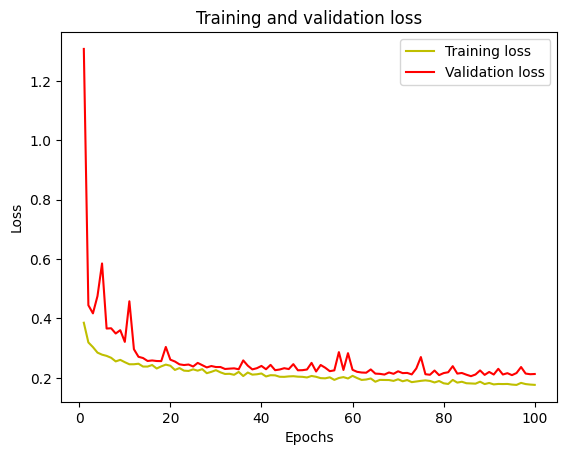

In [ ]:
# Plot the training and validation loss at each epoch

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

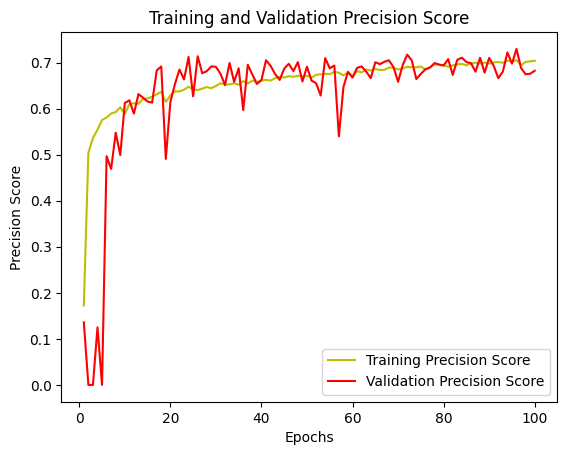

In [ ]:
# Plot training and validation precision score at every epoch

p_scr = history.history['precision']
val_p_scr = history.history['val_precision']

plt.plot(epochs, p_scr, 'y', label='Training Precision Score')
plt.plot(epochs, val_p_scr, 'r', label='Validation Precision Score')
plt.title('Training and Validation Precision Score')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.show()

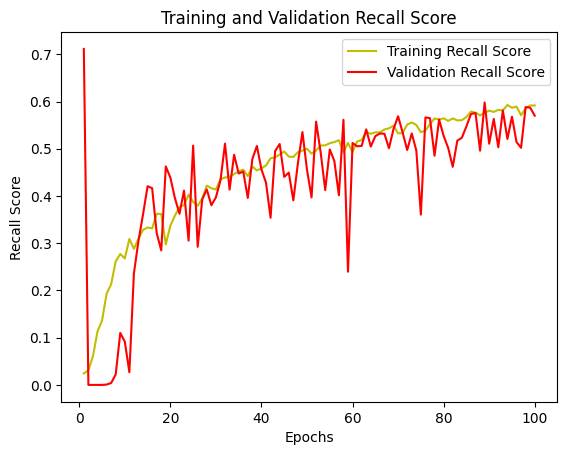

In [ ]:
# Plot training and validation recall score at every epoch

r_scr = history.history['recall']
val_r_scr = history.history['val_recall']

plt.plot(epochs, r_scr, 'y', label='Training Recall Score')
plt.plot(epochs, val_r_scr, 'r', label='Validation Recall Score')
plt.title('Training and Validation Recall Score')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.show()

In [ ]:
# Restore the weights
model.load_weights('NL_unet_nl.h5')


# Model Prediction/Testing

In [ ]:
x_test = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
y_test = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.float32)


for k in x_test_dict.keys():
    # Create patches
    x_patches = perform_gridwise_sampling(x_test_dict[k], PATCHSIZE)
    y_patches = perform_gridwise_sampling(y_test_dict[k], PATCHSIZE)

    # Insert patches into x_train and y_train data set
    x_test = np.concatenate((x_test, x_patches), axis=0)
    y_test = np.concatenate((y_test, y_patches), axis=0)


# visualize_data(x_test[1], f"Test patch sample {1}")
# visualize_labels(y_test[1], f"Test patch sample {1}", LEGEND)

1/1 [==============================] - 0s 52ms/step


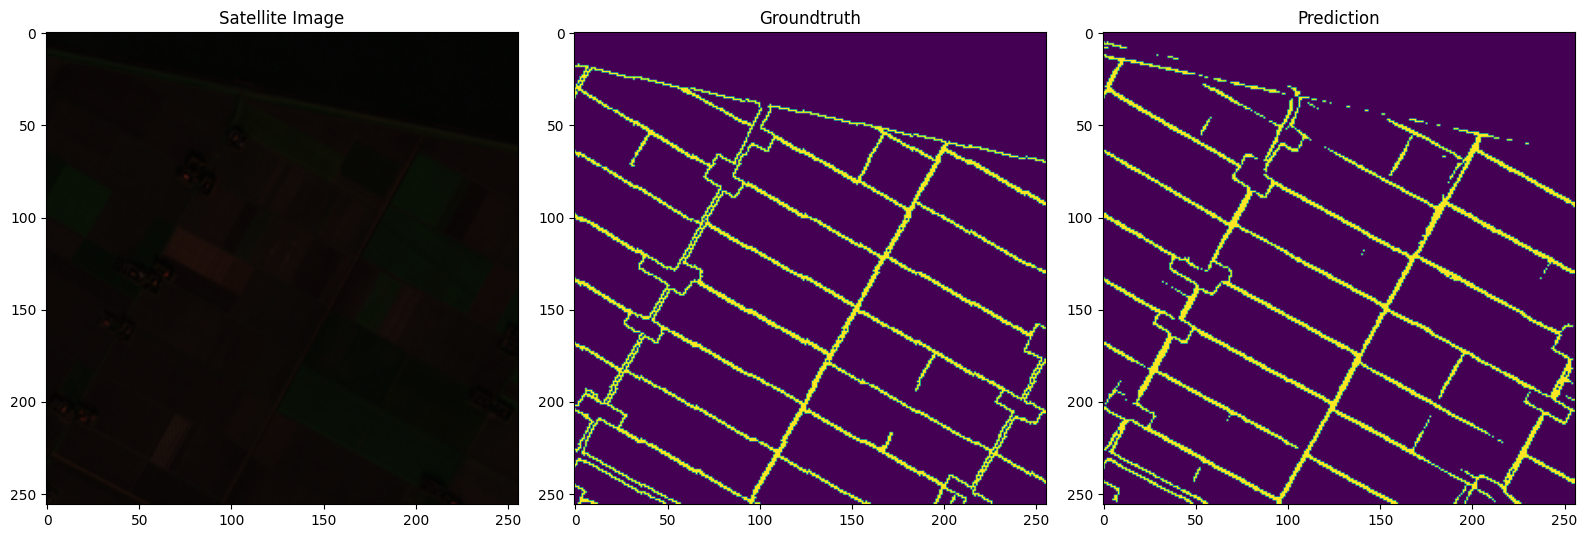

In [ ]:
# Predict on test dataset
i = 100
y_pred = model.predict(np.expand_dims(x_test[i],0))
y_pred = np.squeeze(y_pred, axis=0)
result = np.where(y_pred > 0.5, 1, 0)

# Display Prediction
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(x_test[i][:,:,[0,1,2]])
axs[0].set_title("Satellite Image")
axs[1].imshow(y_test[i])
axs[1].set_title("Groundtruth")
axs[2].imshow(result)
axs[2].set_title("Prediction")

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
loss, acc = model.evaluate(x_test, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
# Save the model
model.save(f"./NL_unet_model_100ep.h5")